In [1]:
%reload_ext autoreload
%autoreload 2

In [6]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from collections import defaultdict

# from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [5]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

# def draw_wordcloud(msg_content, week):    
#     # word cloud visualization
#     allWords = ' '.join([twts for twts in msg_content])
#     wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
#                             max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
#     plt.figure(figsize=(15, 7.5))
#     plt.imshow(wordCloud, interpolation="bilinear")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.title(f'WordCloud for {week}', size=30)
#     plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

### Top 10 and bottom 10 users by reply count

In [122]:
data_loader = SlackDataLoader("../data")
all_channels = data_loader.get_channels()
userNamesById, userIdsByName = data_loader.get_user_map()

In [25]:


reactions = data_loader.parse_slack_reaction("../data/all-week1", "all-week1")
users_replay_count = {user_id:0 for user_id in userNamesById.keys()}


for channel in all_channels:
    channel_user_replay_count = utils.user_reply_count_on_channel(f"../data/{channel["name"]}")
    for user_id, replay_count in channel_user_replay_count.items():
        users_replay_count[user_id] += replay_count

sorted_users_replay_count = list(sorted(users_replay_count.items(), key=lambda x:x[1], reverse=True))
print(sorted_users_replay_count)

[('U03V1AM5TFA', 420), ('U03UVHCV6KB', 346), ('U03UG32J3PC', 251), ('U03UUR571A5', 242), ('U03UG4Q7V42', 240), ('U03UD68RQH3', 223), ('U03V6HMRPGQ', 209), ('U03UH397319', 201), ('U03UJGP0C68', 188), ('U03U1FNPEUX', 167), ('U03V785NLSU', 155), ('U03U1HAG9TR', 149), ('U03UJKJGRAQ', 143), ('U03UJN29Y4C', 126), ('U03UHB8CXDY', 117), ('U03UG1Z21JP', 110), ('U03UG0YHAUT', 109), ('U03U93GNNVB', 105), ('U03UJGRN5E0', 82), ('U03UFV7HFNF', 75), ('U03UKL27B0R', 75), ('U03U9EJR362', 71), ('U03UD5B7C3X', 71), ('U03TEPYRM2P', 70), ('U03UUS0MZCZ', 67), ('U03T89ACUUW', 56), ('U03V5Q9N516', 55), ('U03V61VGQG0', 53), ('U03UUP56MDF', 52), ('U03TT5KEYCF', 49), ('U03UJH1EQQL', 49), ('U03UG0SFHGT', 46), ('U03UUMM7Y8H', 43), ('U03U9DB7REG', 39), ('U03U9FWPNCE', 36), ('U03UFV7TUTV', 33), ('U03UAKATQ22', 32), ('U03UD4FEDHB', 31), ('U03U1J51VFZ', 30), ('U03UG5VFN03', 27), ('U03V8LHPDME', 25), ('U03UL5LSTG9', 22), ('U03U1GHT39V', 19), ('U03UUMR26Q1', 19), ('U03U4GULU3Y', 16), ('U03UUN8M4RX', 15), ('U03UG1RTXAP',

In [26]:
# which user has the highest number of reply counts?
print("Top 10 users by replay count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_replay_count[i][0]]}, with replay count: {sorted_users_replay_count[i][1]}")

Top 10 users by replay count: 
1. username: Vanessa, with replay count: 420
2. username: Travis, with replay count: 346
3. username: April, with replay count: 251
4. username: Amy, with replay count: 242
5. username: Phillip, with replay count: 240
6. username: Brady, with replay count: 223
7. username: Cristian, with replay count: 209
8. username: Brenda, with replay count: 201
9. username: Judith, with replay count: 188
10. username: Joshua, with replay count: 167


In [30]:

print("Bottom 10 users by replay count: ")
index = 1
for i in range(len(sorted_users_replay_count)-1, len(sorted_users_replay_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_replay_count[i][0]]}, with replay count: {sorted_users_replay_count[i][1]}")
    index += 1

Bottom 10 users by replay count: 
1. username: Audrey, with replay count: 0
2. username: Kenneth, with replay count: 0
3. username: Kathleen, with replay count: 0
4. username: Paul, with replay count: 0
5. username: Claudia, with replay count: 0
6. username: Holly, with replay count: 0
7. username: Christopher, with replay count: 0
8. username: Blake, with replay count: 0
9. username: Glen, with replay count: 0
10. username: Dana, with replay count: 0


### Top 10 and bottom 10 users by mention count

In [42]:
users_mention_count = {user_id:0 for user_id in userNamesById.keys()}

for channel in all_channels:
    channel_users_metions_count = utils.get_user_mentions_from_channel(f"../data/{channel["name"]}")
   
    for user_id, mention_count in channel_users_metions_count.items():
        users_mention_count[user_id] += mention_count


sorted_users_mention_count = list(sorted(users_mention_count.items(), key=lambda x:x[1], reverse=True))
print(sorted_users_mention_count)

[('U03V1AM5TFA', 198), ('U03TEPYRM2P', 186), ('U03UUR571A5', 183), ('U03UKL27B0R', 178), ('U03UG32J3PC', 173), ('U03UVHCV6KB', 172), ('U03UJGP0C68', 139), ('U03UG4Q7V42', 136), ('U03UD68RQH3', 135), ('U03UJKJGRAQ', 123), ('U03V6HMRPGQ', 99), ('U03U9DB7REG', 94), ('U03U1HAG9TR', 92), ('U03U1FNPEUX', 86), ('U03V8LHPDME', 86), ('U03V785NLSU', 80), ('U03UH397319', 72), ('U03UP7V9Q57', 72), ('U03UUN8M4RX', 70), ('U03U93GNNVB', 61), ('U03UJGRN5E0', 61), ('U03UD4FEDHB', 56), ('U03T89ACUUW', 54), ('U03UUP56MDF', 54), ('U03UJN29Y4C', 52), ('U03U9FWPNCE', 51), ('U03U1GHT39V', 50), ('U03UG1Z21JP', 50), ('U03UUS0MZCZ', 47), ('U03V61VGQG0', 47), ('U03U4GULU3Y', 46), ('U03TT5KEYCF', 43), ('U03UL5LSTG9', 43), ('U03V5Q9N516', 37), ('U03UFV7HFNF', 35), ('U03U9EJR362', 34), ('U03UG0SFHGT', 34), ('U03UD5B7C3X', 31), ('U03TX2VN6H5', 30), ('U03UG0YHAUT', 26), ('U03UJH1EQQL', 24), ('U03U1J51VFZ', 22), ('U03UHB8CXDY', 22), ('U03UUMR26Q1', 22), ('U03UFV7TUTV', 20), ('U03UG5VFN03', 18), ('U03UUMM7Y8H', 17), ('

In [43]:
print("Top 10 users by mention count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_mention_count[i][0]]}, with mention count: {sorted_users_mention_count[i][1]}")

Top 10 users by mention count: 
1. username: Vanessa, with mention count: 198
2. username: Garrett, with mention count: 186
3. username: Amy, with mention count: 183
4. username: Brittany, with mention count: 178
5. username: April, with mention count: 173
6. username: Travis, with mention count: 172
7. username: Judith, with mention count: 139
8. username: Phillip, with mention count: 136
9. username: Brady, with mention count: 135
10. username: Brian, with mention count: 123


In [44]:
print("Bottom 10 users by mention count: ")
index = 1
for i in range(len(sorted_users_mention_count)-1, len(sorted_users_mention_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_mention_count[i][0]]}, with mention count: {sorted_users_mention_count[i][1]}")
    index += 1

Bottom 10 users by mention count: 
1. username: Audrey, with mention count: 0
2. username: Kenneth, with mention count: 0
3. username: Kathleen, with mention count: 0
4. username: Paul, with mention count: 0
5. username: David, with mention count: 0
6. username: Claudia, with mention count: 0
7. username: Holly, with mention count: 0
8. username: Christopher, with mention count: 0
9. username: Blake, with mention count: 0
10. username: Glen, with mention count: 0


### Top 10 and bottom 10 users by Message count

In [59]:
users_messages_count = {user_id:0 for user_id in userNamesById.keys()}

for channel in all_channels:
    channel_users_messages_count = utils.get_user_message_count_from_channel(f"../data/{channel["name"]}")
    for user_id, message_count in channel_users_messages_count.items():
        users_messages_count[user_id] = users_messages_count.get(user_id, 0) + message_count 

sorted_users_messages_count = list(sorted(users_messages_count.items(), key=lambda x:x[1], reverse=True))
print(sorted_users_messages_count)

[('U03V1AM5TFA', 1554), ('U03UUR571A5', 1206), ('U03UVHCV6KB', 1178), ('U03UG32J3PC', 1070), ('U03UH397319', 910), ('U03V6HMRPGQ', 902), ('U03UG4Q7V42', 803), ('U03UD68RQH3', 706), ('U03UJGP0C68', 675), ('U03U1FNPEUX', 575), ('U03UG0YHAUT', 554), ('U03UHB8CXDY', 486), ('U03UJN29Y4C', 473), ('U03UJKJGRAQ', 458), ('U03U93GNNVB', 445), ('U03UJGRN5E0', 428), ('U03V61VGQG0', 424), ('U03UUP56MDF', 422), ('U03U1HAG9TR', 415), ('U03V785NLSU', 411), ('U03U9EJR362', 399), ('U03UG1Z21JP', 388), ('U03UFV7HFNF', 357), ('U03UD4FEDHB', 337), ('U03UG5VFN03', 314), ('U03V5Q9N516', 294), ('U03UJH1EQQL', 287), ('U03U9FWPNCE', 282), ('U03TEPYRM2P', 222), ('U03UKL27B0R', 220), ('U03UD5B7C3X', 216), ('U03UG0SFHGT', 215), ('U03UUS0MZCZ', 194), ('U03U1J51VFZ', 189), ('U03T89ACUUW', 185), ('U03U1GHT39V', 179), ('U03UFV7TUTV', 175), ('U03UUMR26Q1', 162), ('U03TT5KEYCF', 156), ('U03UUMM7Y8H', 139), ('U03UAKATQ22', 116), ('U03U9DB7REG', 113), ('U03UUN8M4RX', 87), ('U03V8LHPDME', 84), ('U03UL5LSTG9', 82), ('U03U4G

In [49]:

print("Top 10 users by messages count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_messages_count[i][0]]}, with message count: {sorted_users_messages_count[i][1]}")

Top 10 users by messages count: 
1. username: Vanessa, with message count: 1554
2. username: Amy, with message count: 1206
3. username: Travis, with message count: 1178
4. username: April, with message count: 1070
5. username: Brenda, with message count: 910
6. username: Cristian, with message count: 902
7. username: Phillip, with message count: 803
8. username: Brady, with message count: 706
9. username: Judith, with message count: 675
10. username: Joshua, with message count: 575


In [50]:
print("Bottom 10 users by messages count: ")
index = 1
for i in range(len(sorted_users_mention_count)-1, len(sorted_users_mention_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_mention_count[i][0]]}, with message count: {sorted_users_mention_count[i][1]}")
    index += 1

Bottom 10 users by messages count: 
1. username: Audrey, with message count: 0
2. username: Kenneth, with message count: 0
3. username: Kathleen, with message count: 0
4. username: Paul, with message count: 0
5. username: David, with message count: 0
6. username: Claudia, with message count: 0
7. username: Holly, with message count: 0
8. username: Christopher, with message count: 0
9. username: Blake, with message count: 0
10. username: Glen, with message count: 0


### Top 10 and bottom 10 users by Reaction count

In [60]:
users_reactions_count = {user_id:0 for user_id in userNamesById.keys()}

for channel in all_channels:
    channel_user_reactions_count = utils.get_user_reaction_count_from_channel(f"../data/{channel["name"]}")
    for key, value in channel_user_reactions_count.items():
        users_reactions_count[key] = users_reactions_count.get(key, 0) + value

sorted_users_reactions_count = list(sorted(users_reactions_count.items(), key=lambda x:x[1], reverse=True))
print(sorted_users_reactions_count)

[('U03UVHCV6KB', 834), ('U03UG4Q7V42', 758), ('U03UG32J3PC', 711), ('U03U1HAG9TR', 626), ('U03UUR571A5', 572), ('U03UFV7HFNF', 491), ('U03V6HMRPGQ', 461), ('U03U1FNPEUX', 457), ('U03UD68RQH3', 457), ('U03U9EJR362', 427), ('U03UJKJGRAQ', 414), ('U03V1AM5TFA', 413), ('U03UJGP0C68', 338), ('U03V785NLSU', 312), ('U03UG1Z21JP', 288), ('U03UG0YHAUT', 247), ('U03UG0SFHGT', 246), ('U03UJN29Y4C', 194), ('U03UH397319', 182), ('U03UG5VFN03', 174), ('U03UD5B7C3X', 153), ('U03UFV7TUTV', 142), ('U03UJGRN5E0', 122), ('U03U1J51VFZ', 112), ('U03UHB8CXDY', 112), ('U03UD4FEDHB', 100), ('U03UAKATQ22', 87), ('U03UG1RTXAP', 85), ('U03V5Q9N516', 74), ('U03UJH1EQQL', 68), ('U03V61VGQG0', 63), ('U03UUS0MZCZ', 60), ('U03T89ACUUW', 57), ('U03U9DB7REG', 54), ('U03UL5LSTG9', 54), ('U03UUMM7Y8H', 54), ('U03TT5KEYCF', 52), ('U03U1GHT39V', 43), ('U03UUMR26Q1', 43), ('U03U9FWPNCE', 37), ('U03UKGSDGSG', 22), ('U03TEPYRM2P', 20), ('U03V8LHPDME', 18), ('U03U4GULU3Y', 16), ('U03UKL27B0R', 14), ('U03UG569P7U', 11), ('U03UY

In [61]:

print("Top 10 users by reactions count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_reactions_count[i][0]]}, with reaction count: {sorted_users_reactions_count[i][1]}")

Top 10 users by reactions count: 
1. username: Travis, with reaction count: 834
2. username: Phillip, with reaction count: 758
3. username: April, with reaction count: 711
4. username: Robert, with reaction count: 626
5. username: Amy, with reaction count: 572
6. username: Miguel, with reaction count: 491
7. username: Cristian, with reaction count: 461
8. username: Joshua, with reaction count: 457
9. username: Brady, with reaction count: 457
10. username: Nicholas, with reaction count: 427


In [64]:
print("Bottom 10 users by reactions count: ")
index = 1
for i in range(len(sorted_users_reactions_count)-1, len(sorted_users_reactions_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_reactions_count[i][0]]}, with reaction count: {sorted_users_reactions_count[i][1]}")
    index += 1

Bottom 10 users by reactions count: 
1. username: Audrey, with reaction count: 0
2. username: Kenneth, with reaction count: 0
3. username: Kathleen, with reaction count: 0
4. username: Paul, with reaction count: 0
5. username: David, with reaction count: 0
6. username: Claudia, with reaction count: 0
7. username: Holly, with reaction count: 0
8. username: Glen, with reaction count: 0
9. username: Dana, with reaction count: 0
10. username: Randy, with reaction count: 0


### Top 10 message by reply count

In [67]:
list_of_dfs = []
for channel in all_channels:
    df = data_loader.slack_parser(f"../data/{channel["name"]}")
    list_of_dfs.append(df)
    
combined_df = pd.concat(list_of_dfs, ignore_index=True)
combined_df.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,*<!here> Community Building Session REMINDER!*...,Vanessa Norman,1662637801.047169,broadcast,0,0,0,0,0,all-community-building
1,message,Sweet music on Google meet now\n:point_right: ...,Vanessa Norman,1662638240.075389,text,0,0,0,0,0,all-community-building
2,message,yes,Nancy Craig,1662638433.844559,text,0,0,0,0,0,all-community-building
3,message,yes,Jennifer Foley,1662638437.828849,text,0,0,0,0,0,all-community-building
4,message,Yes,Debra Lawrence,1662638453.483379,text,0,0,0,0,0,all-community-building


In [68]:
# Get the top 10 messages with the highest reply_count
top_10_messages = combined_df.nlargest(10, 'reply_count')
print("Top 10 messages by reply count")
print(top_10_messages[['msg_content', 'reply_count']])

Top 10 messages by reply count
                                             msg_content  reply_count
7215           <@U03V1AM5TFA> how many crushes you have?           75
6460   First Impression: People think I am older than...           63
15234  1. How do I find my jupyter notebook file in m...           61
4454   How many here follow football so much? I think...           57
10061                    Ethiopian New year Loading ....           54
11383  Hello\n1. <@U03UVHCV6KB>\n2. <@U03UG5VFN03>\n3...           45
16512  <@U03UUR571A5> Solutions to funding account an...           44
10529  We had a plan to meet today 2:00 EAT at Friend...           36
11538  *<!here> REMINDER*:timer_clock:\n\n*Please not...           33
2375   the debate was great. We <@U03U1J51VFZ>, <@U03...           31


### Top 10 message by Reaction count

In [69]:
list_of_dfs = []
for channel in all_channels:
    df = data_loader.parse_slack_reaction(f"../data/{channel["name"]}", channel["name"])
    list_of_dfs.append(df)
    

combined_df = pd.concat(list_of_dfs, ignore_index=True)

combined_df['reaction_count'] = pd.to_numeric(combined_df['reaction_count'], errors='coerce')
combined_df.head()


,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,fire,1,U03U9FWPNCE,*<!here>* Good morning Community! We are very ...,U03V1AM5TFA,all-community-building
1,heart_eyes,3,"U03UG4Q7V42,U03UFV7HFNF,U03UG5VFN03",*<!here> Community Building Session REMINDER!*...,U03V1AM5TFA,all-community-building
2,raised_hands,1,U03UVHCV6KB,Many songs including Lampa Dina,U03U9FWPNCE,all-community-building
3,raised_hands,1,U03UVHCV6KB,lampadina,U03UG1Z21JP,all-community-building
4,raised_hands,1,U03UD68RQH3,,U03V6HMRPGQ,all-community-building


In [70]:
# Drop rows with NaN in 'reaction_count'
df_reaction_cleaned = combined_df.dropna(subset=['reaction_count'])

# Get the top 10 messages with the highest numeric 'reaction_count'
top_10_messages_with_highest_reaction_count = df_reaction_cleaned.nlargest(10, 'reaction_count')

# Print the result
print(top_10_messages_with_highest_reaction_count[['message', 'reaction_count']])

                                                message  reaction_count
4693  Good morning winners, welcome to week 9 of wee...              17
395                                                                  16
1499  My reactions when am not finished the task bef...              16
4075  Little known fact - all 10 Academy technical t...              16
301   *Here are some other stories from people that ...              15
1881  *Guys <!here>.... Make sure to come back from ...              15
4488  Welcome to week6 everyone. By Friday, we’ll be...              15
1012  1- let me open my VPN, where do you want me to...              14
3358  <!channel>\nThere will be no careers exercise ...              14
795           meat that is even more raw <@U03UUR571A5>              13


### Top 10 message by Mention count

In [87]:
message_mentions = []
for channel in all_channels:
    channel_message_mentions = utils.get_message_mentions_count_from_channel(f"../data/{channel["name"]}")
    message_mentions.extend(channel_message_mentions)

sorted_messages = sorted(
        message_mentions,
        key=lambda x: x.get("mentions_count", 0),
        reverse=True
    )

print("Top 10 messages by mention count:")
for mesg in sorted_messages[:10]:
    print(f"Message text: {mesg["text"]} with mention count: {mesg["mentions_count"]}")


Top 10 messages by mention count:
Message text: I am grateful for <@U03U93GNNVB>, <@U03UUN8M4RX> for building a community , for all <@U03TX2VN6H5> for making the journey fruitful,Thank you the tutires <@U03UKL27B0R> <@U03UP7V9Q57>, <@U03V8LHPDME>, <@U03U9DB7REG>, <@U03U4GULU3Y> <@U03UP7V9Q57> <@U03TT5KEYCF> <@U03TEPYRM2P> <@U03UL5LSTG9> for answering all my questions and my annoying prompts.
Thank you the wonderful teams that I worked with and the people I asked for help, <@U03UJGP0C68> <@U03UG4Q7V42> <@U03U1FNPEUX> <@U03U1HAG9TR> <@U03UUR571A5> <@U03UG0YHAUT> <@U03UJKJGRAQ> <@U03UD5B7C3X> <@U03UVHCV6KB> <@U03UUS0MZCZ> <@U03UD68RQH3> and mostly <@U03UG32J3PC> for his continuous support
Thank you all from the bottom of my heart
and Last but not least the amazing <@U03V1AM5TFA> for making the journey enjoy full with mention count: 25
Message text: Knowing <!here> is just great one way or the other I learned a lot from you guys....
<@U03U1FNPEUX>, <@U03UKL27B0R>, <@U03U9DB7REG>, <@U03V8LH

### Messages Count Of Channel Vs Sum of replies and reactions

In [89]:
list_of_dfs = []
x_axis_message_count = {}
y_axis_reply_reaction_count = {}

for channel in all_channels:
    replay_df = data_loader.slack_parser(f"../data/{channel["name"]}")
    reaction_df = data_loader.parse_slack_reaction(f"../data/{channel["name"]}", channel["name"])

    list_of_dfs.append(df)

    total_reply_count = replay_df['reply_count'].sum()
    total_reaction_count = reaction_df['reaction_count'].sum()

    x_axis_message_count[channel["name"]] = len(replay_df)
    y_axis_reply_reaction_count[channel["name"]] = total_reply_count + total_reaction_count


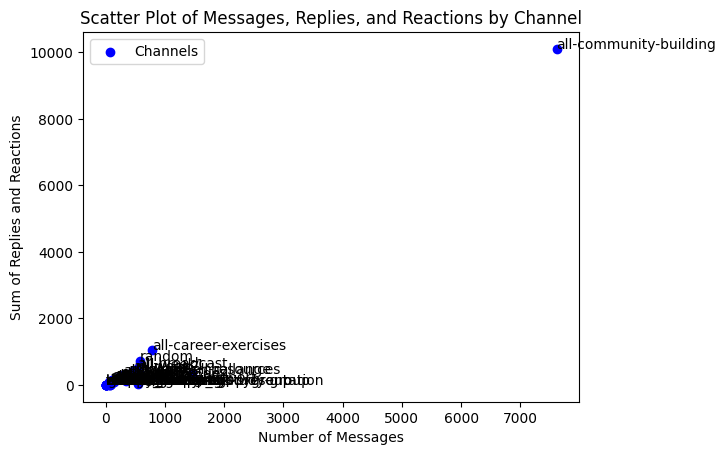

In [90]:
channels = list(x_axis_message_count.keys())
x_values = list(x_axis_message_count.values())
y_values = list(y_axis_reply_reaction_count.values())

# Scatter plot
plt.scatter(x_values, y_values, c='blue', label='Channels')

# Add labels and title
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies and Reactions')
plt.title('Scatter Plot of Messages, Replies, and Reactions by Channel')

# Add channel labels
for i, channel in enumerate(channels):
    plt.annotate(channel, (x_values[i], y_values[i]))

# Show legend
plt.legend()

# Show the plot
plt.show()

- all-community-building appear at the top right corner of the graph having the highest activity

#### Fraction of Messages Replied Within 5 Minutes and Scatter Plot of Time Difference vs Time of Day with Channels Colored

In [111]:
from datetime import datetime

def calculate_time_difference_seconds(start_time, end_time):
    """
    Calculate the time difference in seconds between two timestamps.

    Args:
        start_time (float): Start timestamp.
        end_time (float): End timestamp.

    Returns:
        float: Time difference in seconds.
    """
    start_datetime = datetime.utcfromtimestamp(float(start_time))
    end_datetime = datetime.utcfromtimestamp(float(end_time))
    time_difference_seconds = (end_datetime - start_datetime).total_seconds()
    return time_difference_seconds

In [116]:
channels_stamps = {}
channels_no_reply_count = {}
message_reply_less_than_5_minutes = 0
total_messages = 0

for channel in all_channels:
    stamps, no_reply_messages_count = utils.get_messages_reply_timestamp_from_channel(f"../data/{channel["name"]}")
    channels_stamps[channel["name"]] = stamps
    channels_no_reply_count[channel["name"]] = no_reply_messages_count

    for msg_timestamp, reply_timestamp in stamps:

        time_difference = calculate_time_difference_seconds(msg_timestamp, reply_timestamp)

        if time_difference <= 300:  # 300 seconds = 5 minutes
            message_reply_less_than_5_minutes += 1

    total_messages += (len(stamps) + no_reply_messages_count)

print("Total number of messages: ",total_messages )
print("Number messages replied with in 5 minutes: ", message_reply_less_than_5_minutes)
print("The Fraction of messages replied with in 5 minutes: ", message_reply_less_than_5_minutes/total_messages)

/tmp/ipykernel_4271/3628310941.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  start_datetime = datetime.utcfromtimestamp(float(start_time))
/tmp/ipykernel_4271/3628310941.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  end_datetime = datetime.utcfromtimestamp(float(end_time))


Total number of messages:  20010
Number messages replied with in 5 minutes:  684
The Fraction of messages replied with in 5 minutes:  0.034182908545727135


/tmp/ipykernel_4271/3628310941.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  start_datetime = datetime.utcfromtimestamp(float(start_time))
/tmp/ipykernel_4271/3628310941.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  end_datetime = datetime.utcfromtimestamp(float(end_time))
/tmp/ipykernel_4271/1139613599.py:5: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  y_values = [datetime.utcfromtimestamp(float(msg_timestamp))

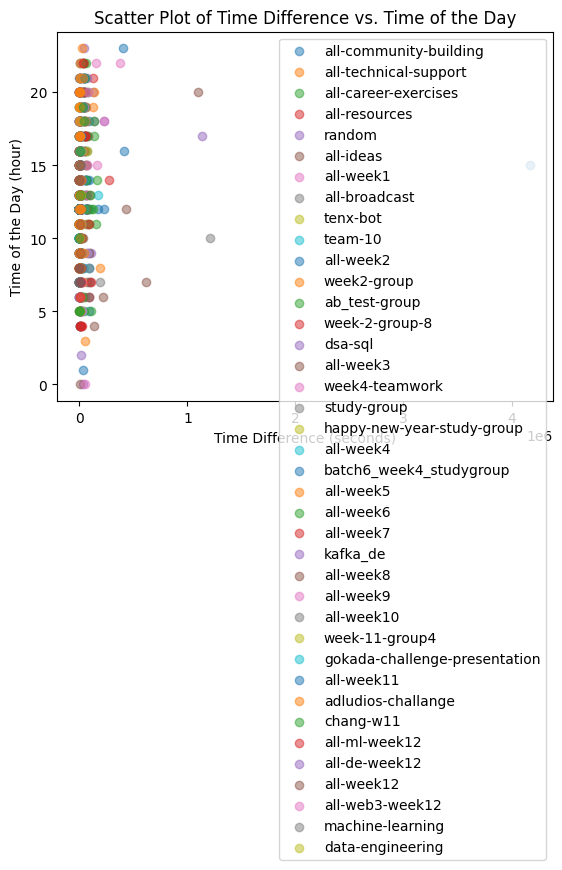

In [117]:

# Plotting
fig, ax = plt.subplots()
for channel_name, message_timestamps in channels_stamps.items():
    x_values = [calculate_time_difference_seconds(msg_timestamp, reply_timestamp) for msg_timestamp, reply_timestamp in message_timestamps]
    y_values = [datetime.utcfromtimestamp(float(msg_timestamp)).hour for msg_timestamp, _ in message_timestamps]

    ax.scatter(x_values, y_values, label=channel_name, alpha=0.5)

ax.set_xlabel('Time Difference (seconds)')
ax.set_ylabel('Time of the Day (hour)')
ax.set_title('Scatter Plot of Time Difference vs. Time of the Day')
ax.legend()
plt.show()

In [ ]:
# Visualize reply counts per user per channel


In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?